In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.0.0  Device: cpu


In [3]:
batch_size = 32

train_dataset = datasets.MNIST('../data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('../data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

9.3%

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100.0%
31.8%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


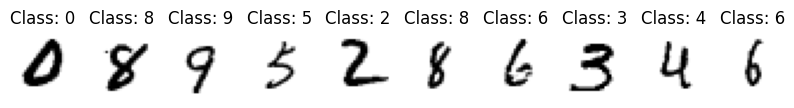

In [5]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 50)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)


In [7]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [8]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

In [9]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.321211
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.091914
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.330549
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.930157
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.645455
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.685166
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.669469
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.566814
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.606578
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.913150

Validation set: Average loss: 0.3625, Accuracy: 9004/10000 (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.281753
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.601537
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.391055
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.201397
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.550270
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.337319
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.476457
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.513110
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.27

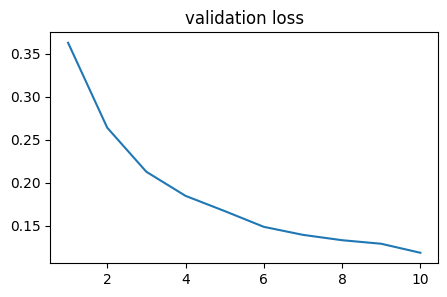

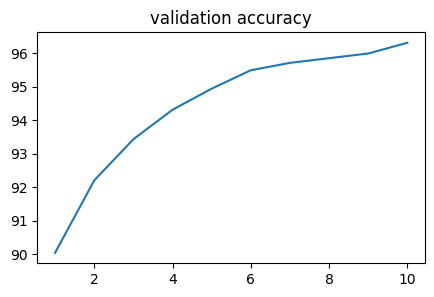

In [10]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

In [14]:
len(model.state_dict()['fc1.weight'])

50

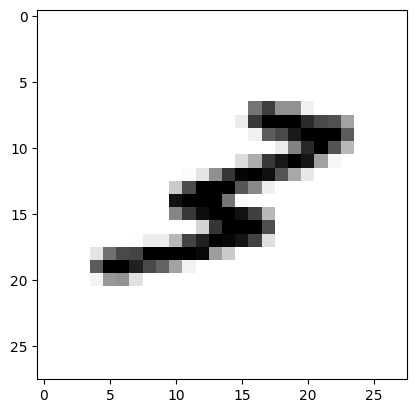

In [149]:
# get the first img
img = X_train[22,:,:,:].numpy().reshape(28,28)
# plot the first img
plt.imshow(img, cmap='gray_r')

In [150]:
flatten = img.reshape(1, 28*28)

In [151]:
# Do feedforward
output_fc1 = model.state_dict()['fc1.weight'].numpy().dot(flatten.T) + model.state_dict()['fc1.bias'].numpy().reshape(50,1)
output_fc1_relu = np.maximum(output_fc1, 0)

In [152]:
output_fc2 = model.state_dict()['fc2.weight'].numpy().dot(output_fc1_relu) + model.state_dict()['fc2.bias'].numpy().reshape(50,1)
output_fc2_relu = np.maximum(output_fc2, 0)

In [154]:
output_fc3 = model.state_dict()['fc3.weight'].numpy().dot(output_fc2_relu) + model.state_dict()['fc3.bias'].numpy().reshape(10,1)
output_fc3

array([[-3.5755522 ],
       [ 0.6460015 ],
       [ 3.872107  ],
       [ 2.8812754 ],
       [-0.11357069],
       [-1.6746212 ],
       [-4.7165456 ],
       [ 2.6314452 ],
       [ 2.2099278 ],
       [-2.2598236 ]], dtype=float32)

In [ ]:
# Do log_softmax
output_fc3 = model.state_dict()['fc3.weight'].numpy().dot(output_fc2_relu) + model.state_dict()['fc3.bias'].numpy().reshape(10,1)
output_fc3_log_softmax = output_fc3 - np.max(output_fc3)
output_fc3_log_softmax = output_fc3_log_softmax - np.log(np.sum(np.exp(output_fc3_log_softmax), axis=0))
output_fc3_log_softmax

array([[-8.097544 ],
       [-3.8759894],
       [-0.6498841],
       [-1.6407157],
       [-4.635562 ],
       [-6.1966124],
       [-9.238537 ],
       [-1.890546 ],
       [-2.3120632],
       [-6.7818146]], dtype=float32)

In [ ]:

# Get the prediction
np.argmax(output_fc3_log_softmax)

In [142]:
# Export this as a .h file
import os
os.makedirs('../c_headers', exist_ok=True)
# Write the .h file
with open('../c_headers/weights.h', 'w') as f:
    # Do this for each layer
    # fc1
    temp = 'const float {}[{}][{}] = '.format('fc1_weights', model.state_dict()['fc1.weight'].shape[0] , model.state_dict()['fc1.weight'].shape[1])
    f.write(temp)
    f.write('{\n')
    for i in range(model.state_dict()['fc1.weight'].shape[0]):
        f.write('{')
        for j in range(model.state_dict()['fc1.weight'].shape[1]):
            # Only 2 floating points
            f.write('{:.6f}'.format(model.state_dict()['fc1.weight'][i][j].item()))
            if j != model.state_dict()['fc1.weight'].shape[1] - 1:
                f.write(', ')
        f.write('}')
        if i != model.state_dict()['fc1.weight'].shape[0] - 1:
            f.write(',\n')
    f.write('\n};\n\n')

    # fc1 bias
    bias_reshape = model.state_dict()['fc1.bias'].numpy().reshape(50,1)
    temp = 'const float {}[{}][{}] = '.format('fc1_bias', bias_reshape.shape[0], bias_reshape.shape[1])
    f.write(temp)
    f.write('{\n')
    for i in range(bias_reshape.shape[0]):
        f.write('{')
        for j in range(bias_reshape.shape[1]):
            # Only 2 floating points
            f.write('{:.6f}'.format(bias_reshape[i][j]))
            if j != bias_reshape.shape[1] - 1:
                f.write(', ')
        f.write('}')
        if i != bias_reshape.shape[0] - 1:
            f.write(',\n')
    f.write('\n};\n\n')
    
    # fc2 
    temp = 'const float {}[{}][{}] = '.format('fc2_weights', model.state_dict()['fc2.weight'].shape[0] , model.state_dict()['fc2.weight'].shape[1])
    f.write(temp)
    f.write('{\n')
    for i in range(model.state_dict()['fc2.weight'].shape[0]):
        f.write('{')
        for j in range(model.state_dict()['fc2.weight'].shape[1]):
            # Only 2 floating points
            f.write('{:.6f}'.format(model.state_dict()['fc2.weight'][i][j].item()))
            if j != model.state_dict()['fc2.weight'].shape[1] - 1:
                f.write(', ')
        f.write('}')
        if i != model.state_dict()['fc2.weight'].shape[0] - 1:
            f.write(',\n')
    f.write('\n};\n\n')

    # fc2 bias
    bias_reshape = model.state_dict()['fc2.bias'].numpy().reshape(50,1)
    temp = 'const float {}[{}][{}] = '.format('fc2_bias', bias_reshape.shape[0], bias_reshape.shape[1])
    f.write(temp)
    f.write('{\n')
    for i in range(bias_reshape.shape[0]):
        f.write('{')
        for j in range(bias_reshape.shape[1]):
            # Only 2 floating points
            f.write('{:.6f}'.format(bias_reshape[i][j]))
            if j != bias_reshape.shape[1] - 1:
                f.write(', ')
        f.write('}')
        if i != bias_reshape.shape[0] - 1:
            f.write(',\n')
    f.write('\n};\n\n')

    # fc3
    temp = 'const float {}[{}][{}] = '.format('fc3_weights', model.state_dict()['fc3.weight'].shape[0] , model.state_dict()['fc3.weight'].shape[1])
    f.write(temp)
    f.write('{\n')
    for i in range(model.state_dict()['fc3.weight'].shape[0]):
        f.write('{')
        for j in range(model.state_dict()['fc3.weight'].shape[1]):
            # Only 2 floating points
            f.write('{:.6f}'.format(model.state_dict()['fc3.weight'][i][j].item()))
            if j != model.state_dict()['fc3.weight'].shape[1] - 1:
                f.write(', ')
        f.write('}')
        if i != model.state_dict()['fc3.weight'].shape[0] - 1:
            f.write(',\n')
    f.write('\n};\n\n')

    # fc3 bias
    bias_reshape = model.state_dict()['fc3.bias'].numpy().reshape(10,1)
    temp = 'const float {}[{}][{}] = '.format('fc3_bias', bias_reshape.shape[0], bias_reshape.shape[1])
    f.write(temp)
    f.write('{\n')
    for i in range(bias_reshape.shape[0]):
        f.write('{')
        for j in range(bias_reshape.shape[1]):
            # Only 2 floating points
            f.write('{:.6f}'.format(bias_reshape[i][j]))
            if j != bias_reshape.shape[1] - 1:
                f.write(', ')
        f.write('}')
        if i != bias_reshape.shape[0] - 1:
            f.write(',\n')
    f.write('\n};\n\n')
    f.close()

In [132]:
# Export the flatten img as a .h file
flatten = flatten.T
with open('../c_headers/flatten_img.h', 'w') as f:
    temp = 'const float {}[{}][{}] = '.format('flatten_img', flatten.shape[0], flatten.shape[1])
    f.write(temp)
    f.write('{\n')
    for i in range(flatten.shape[0]):
        f.write('{')
        for j in range(flatten.shape[1]):
            # Only 2 floating points
            f.write('{:.2f}'.format(flatten[i][j]))
            if j != flatten.shape[1] - 1:
                f.write(', ')
        f.write('}')
        if i != flatten.shape[0] - 1:
            f.write(',\n')
    f.write('\n};\n\n')
    f.close()